Find data here --> www.kaggle.com/c/nlp-getting-started/data

# Imports 

In [14]:
import pandas as pd
import numpy as np

# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings 
warnings.filterwarnings('ignore')

In [15]:
from scripts.utils import Baseline, Stats, Better_Clean

In [16]:
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [52]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

## Read data

In [18]:
train = pd.read_csv('data/train.csv')

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [20]:
target = train.target

In [21]:
target.value_counts() / target.shape[0] * 100

0    57.034021
1    42.965979
Name: target, dtype: float64

<AxesSubplot:>

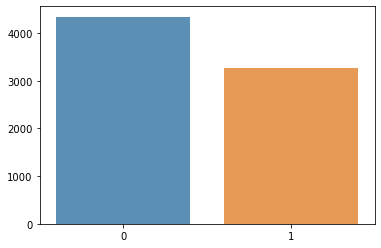

In [22]:
sns.barplot(target.value_counts().index, target.value_counts().values, alpha=0.8)

In [23]:
train.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [24]:
train.text[1]

'Forest fire near La Ronge Sask. Canada'

## EDA

In [25]:
stats_collector = Stats()

In [26]:
train['hashtags'] = train.text.apply(stats_collector.get_hashtags)
train.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]"


### Simple statistics

In [27]:
stats = stats_collector.calculate_stats(train.text)
stats['num_hashtags'] = train.hashtags.apply(len)
stats.head()

,len,n_numbers,numbers_ratio,n_words,avg_word_len,n_letters,n_spaces,n_capitals,capitals_ratio,num_hashtags
0,69,0,0.000000,13,4.307692,56,12,10,0.769231,1
1,38,0,0.000000,7,4.428571,31,6,5,0.714286,0
2,133,0,0.000000,22,4.954545,109,21,2,0.090909,0
3,65,5,0.076923,7,7.142857,50,8,1,0.142857,1
4,88,0,0.000000,16,4.375000,70,16,3,0.187500,2


In [28]:
stats.describe()

,len,n_numbers,numbers_ratio,n_words,avg_word_len,n_letters,n_spaces,n_capitals,capitals_ratio,num_hashtags
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,101.037436,2.040326,0.019333,17.408643,4.584372,77.981348,14.053198,9.923158,0.597444,0.437410
std,33.781325,3.010461,0.027473,6.114081,0.872972,26.332780,5.818518,10.436544,0.666541,1.085629
min,7.000000,0.000000,0.000000,1.000000,2.250000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,0.000000,0.000000,13.000000,4.000000,59.000000,10.000000,3.000000,0.222222,0.000000
50%,107.000000,1.000000,0.010638,18.000000,4.478261,82.000000,14.000000,7.000000,0.444444,0.000000
75%,133.000000,3.000000,0.029126,22.000000,5.000000,102.000000,18.000000,13.000000,0.750000,0.000000
max,157.000000,39.000000,0.428571,33.000000,12.000000,121.000000,55.000000,118.000000,8.000000,13.000000


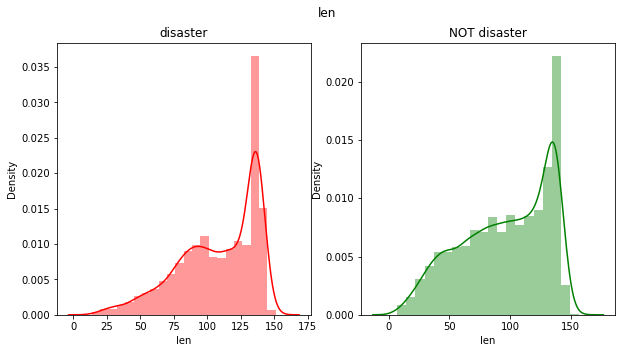

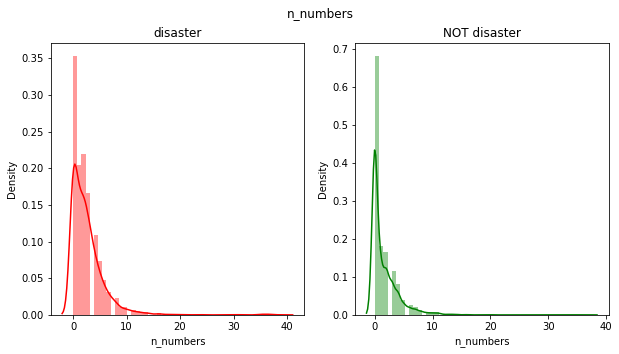

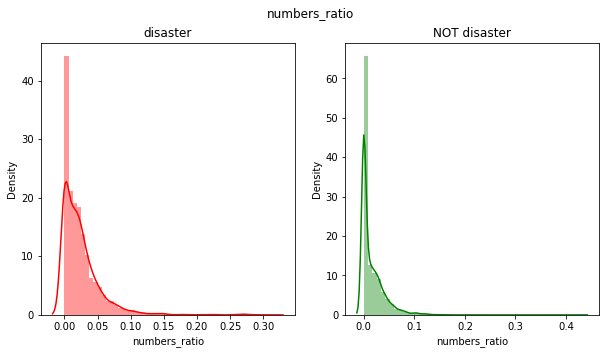

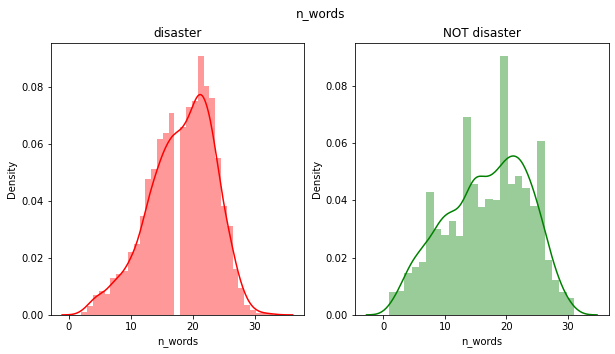

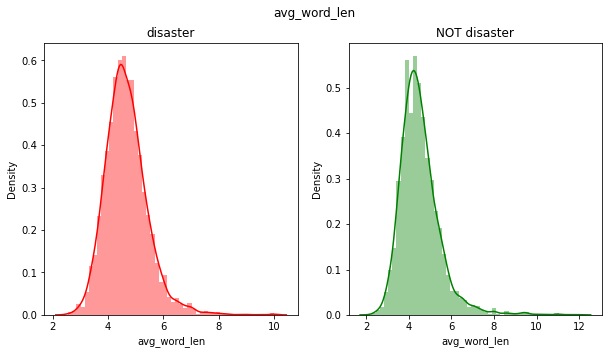

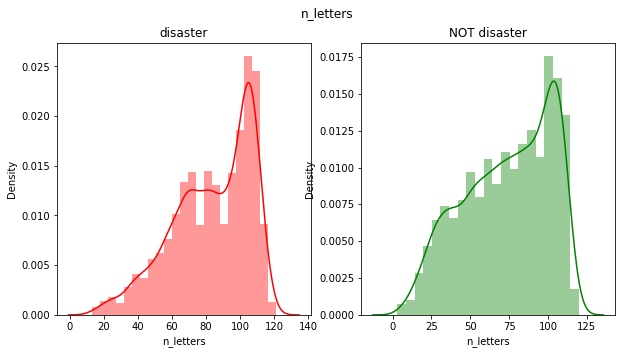

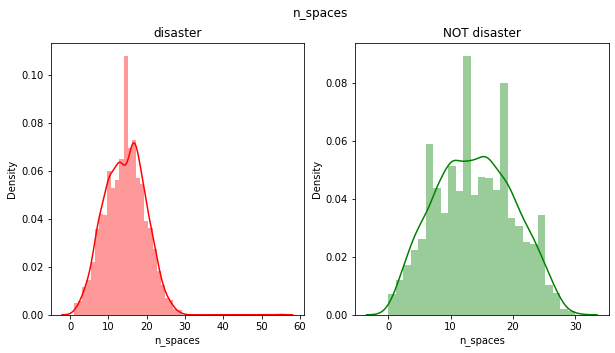

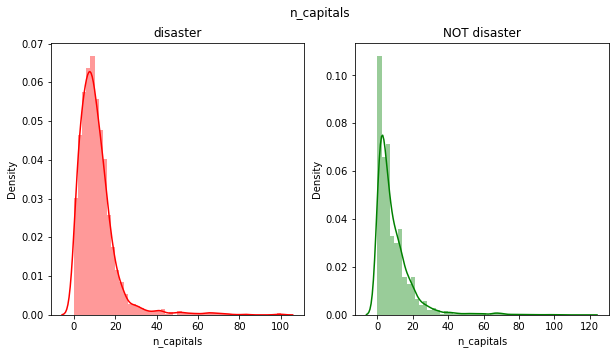

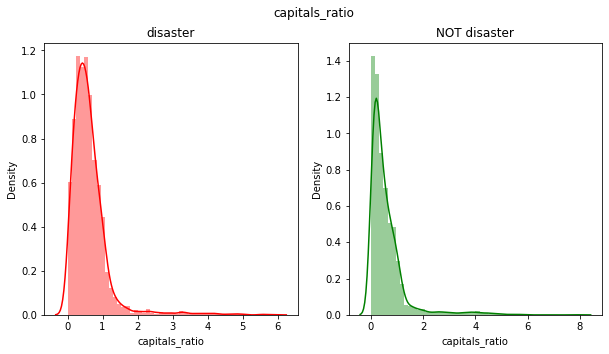

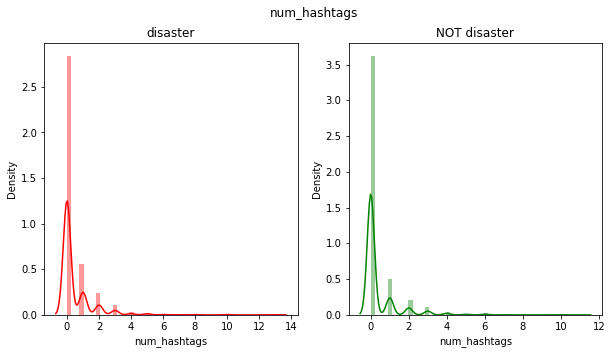

In [29]:
for stat in stats.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
    sns.distplot(stats[target == 1][stat], ax=ax1, color='red')
    ax1.set_title('disaster')
    sns.distplot(stats[target == 0][stat], ax=ax2, color='green')
    ax2.set_title('NOT disaster')
    fig.suptitle(stat)

### Words analysis

**Disaster texts**

In [30]:
preproc = Baseline()

In [31]:
stats_collector.get_corpus_statistics(train[target == 1].text, lambda x: preproc.tokenize(x, cachedStopWords), topn=10)

size of vocabulary is: 7327
most_common_words are:


[('http', 2513),
 ('fire', 266),
 ('bomb', 180),
 ('kill', 158),
 ('news', 140),
 ('amp', 135),
 ('via', 121),
 ('flood', 120),
 ("n't", 120),
 ('disast', 119)]

CountVectorizer(tokenizer=<function <lambda> at 0x000001EF6B3E2160>)

**NOT disaster texts**

In [32]:
stats_collector.get_corpus_statistics(train[target == 0].text, lambda x: preproc.tokenize(x, cachedStopWords), topn=10)

size of vocabulary is: 9935
most_common_words are:


[('http', 2203),
 ("n't", 326),
 ('like', 307),
 ('get', 221),
 ('amp', 209),
 ('new', 168),
 ('go', 141),
 ('one', 135),
 ('love', 116),
 ('bodi', 114)]

CountVectorizer(tokenizer=<function <lambda> at 0x000001EF6941C3A0>)

## Cleaning

What to do?

**Disaster texts**

In [33]:
advanced_cleaning = Better_Clean()

In [34]:
stats_collector.get_corpus_statistics(train[target == 1].text, 
                                      lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords), topn=10)

size of vocabulary is: 7358
most_common_words are:


[('fire', 266),
 ('bomb', 180),
 ('kill', 158),
 ('news', 140),
 ('amp', 135),
 ('via', 121),
 ('flood', 120),
 ('disast', 119),
 ('crash', 113),
 ('california', 111)]

CountVectorizer(tokenizer=<function <lambda> at 0x000001EF690D6E50>)

**NOT disaster texts**

In [35]:
stats_collector.get_corpus_statistics(train[target == 0].text,
                                      lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords), topn=10)

size of vocabulary is: 9991
most_common_words are:


[('like', 307),
 ('get', 221),
 ('amp', 209),
 ('new', 168),
 ('would', 143),
 ('go', 141),
 ('one', 135),
 ('love', 116),
 ('bodi', 114),
 ('bag', 109)]

CountVectorizer(tokenizer=<function <lambda> at 0x000001EF6B44C550>)

In [36]:
train['tokens'] = train.text.apply(lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords, do_stemming=False))
train.head()

,id,keyword,location,text,target,hashtags,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[],"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[],"[residents, asked, ishelter, place, notified, ..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Alaska, wildfires]","[got, sent, photo, ruby, alaska, smoke, wildfi..."


## Baseline: TfIdf + Logreg

In [37]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.2, shuffle=True, stratify=train['target'])

In [38]:
my_pipeline = Pipeline([
    ('vectorizer', preproc.get_vectorizer(lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords))),
    ('clf', LogisticRegression())
])

parameters = {'clf__C': [0.05, 0.1, 1, 5]}

grid_search = GridSearchCV(my_pipeline, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)


In [39]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__C=0.05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... clf__C=0.05, total=   2.7s
[CV] clf__C=0.05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ...................................... clf__C=0.05, total=   2.6s
[CV] clf__C=0.05 .....................................................
[CV] ...................................... clf__C=0.05, total=   2.6s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   2.6s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   2.6s
[CV] clf__C=0.1 ......................................................
[CV] ....................................... clf__C=0.1, total=   2.6s
[CV] clf__C=1 ........................................................
[CV] ......................................... clf__C=1, total=   2.7s
[CV] clf__C=1 ........................................................
[CV] ......................................... clf__C=1, total=   2.7s
[CV] clf__C=1 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   31.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        sublinear_tf=True,
                                                        tokenizer=<function <lambda> at 0x000001EF68C34F70>)),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.05, 0.1, 1, 5]}, scoring='f1', verbose=2)

In [40]:
y_pred = grid_search.predict(X_test.text)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.80      0.71      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



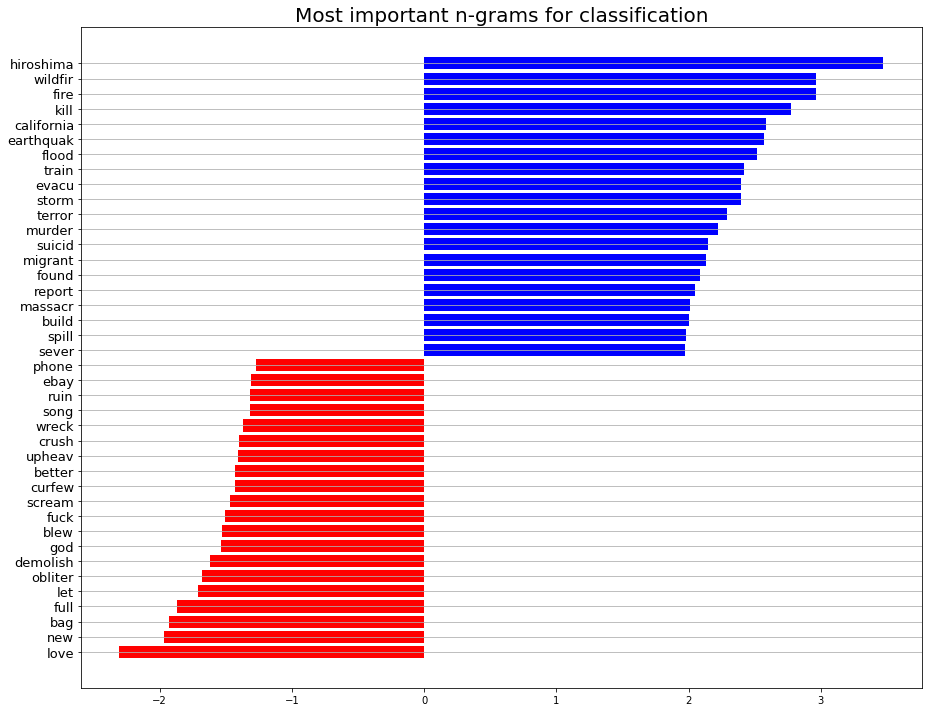

In [42]:
preproc.plot_coeffs(grid_search.best_estimator_.get_params()['steps'][1][1].coef_, grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names())

# SVM

In [45]:
tuned_parameters = [{'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4],
                     'clf__C': [1, 10, 100, 1000]},]

In [46]:
my_pipeline = Pipeline([
    ('vectorizer', preproc.get_vectorizer(lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords))),
    ('clf', SVC())
])


parameters = {'clf__C': [0.05, 0.1, 1, 5]}

grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [47]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   3.9s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   3.8s
[CV] clf__C=1, clf__gamma=0.001, clf__kernel=rbf .....................
[CV] ...... clf__C=1, clf__gamma=0.001, clf__kernel=rbf, total=   3.9s
[CV] clf__C=1, clf__gamma=0.0001, clf__kernel=rbf ....................
[CV] ..... clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, total=   3.8s
[CV] clf__C=1, clf__gamma=0.0001, clf__kernel=rbf ....................
[CV] ..... clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, total=   3.8s
[CV] clf__C=1, clf__gamma=0.0001, clf__kernel=rbf ....................
[CV] ..... clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, total=   3.9s
[CV] clf__C=10, clf__gamma=0.001, clf__kernel=rbf ....................
[CV] ..... clf__C=10, clf__gamma=0.001, clf__kernel=rbf, total=   3.8s
[CV] clf__C=10, clf__gamma=0.001, clf__kernel=rbf ....................
[CV] ..... clf__C=10, clf__gamma=0.001, clf__kernel=rbf, total=   3.9s
[CV] clf__C=10, clf__gamma=0.001, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        sublinear_tf=True,
                                                        tokenizer=<function <lambda> at 0x000001EF69CEF280>)),
                                       ('clf', SVC())]),
             param_grid=[{'clf__C': [1, 10, 100, 1000],
                          'clf__gamma': [0.001, 0.0001],
                          'clf__kernel': ['rbf']}],
             scoring='f1', verbose=2)

In [48]:
grid_search.best_params_

{'clf__C': 1000, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

In [49]:
y_pred = grid_search.predict(X_test.text)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       869
           1       0.76      0.73      0.74       654

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



# NB 


In [53]:
tuned_parameters = [{'clf__alpha': [0, 0.5, 1.0, 5, 10], 'clf__fit_prior':[True, False]}]

In [55]:
my_pipeline = Pipeline([
    ('vectorizer', preproc.get_vectorizer(lambda x: advanced_cleaning.advanced_tokenize(x, cachedStopWords))),
    ('clf', MultinomialNB())
])



grid_search = GridSearchCV(my_pipeline, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)


In [56]:
grid_search.fit(X_train.text, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=   2.6s
[CV] clf__alpha=0, clf__fit_prior=True ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................ clf__alpha=0, clf__fit_prior=True, total=   2.7s
[CV] clf__alpha=0, clf__fit_prior=True ...............................
[CV] ................ clf__alpha=0, clf__fit_prior=True, total=   2.7s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=   2.7s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=   2.8s
[CV] clf__alpha=0, clf__fit_prior=False ..............................
[CV] ............... clf__alpha=0, clf__fit_prior=False, total=   2.8s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=   3.1s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .............. clf__alpha=0.5, clf__fit_prior=True, total=   2.9s
[CV] clf__alpha=0.5, clf__fit_prior=True .............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        sublinear_tf=True,
                                                        tokenizer=<function <lambda> at 0x000001EF69C6DCA0>)),
                                       ('clf', MultinomialNB())]),
             param_grid=[{'clf__alpha': [0, 0.5, 1.0, 5, 10],
                          'clf__fit_prior': [True, False]}],
             scoring='f1', verbose=2)

In [57]:
grid_search.best_params_

{'clf__alpha': 1.0, 'clf__fit_prior': False}

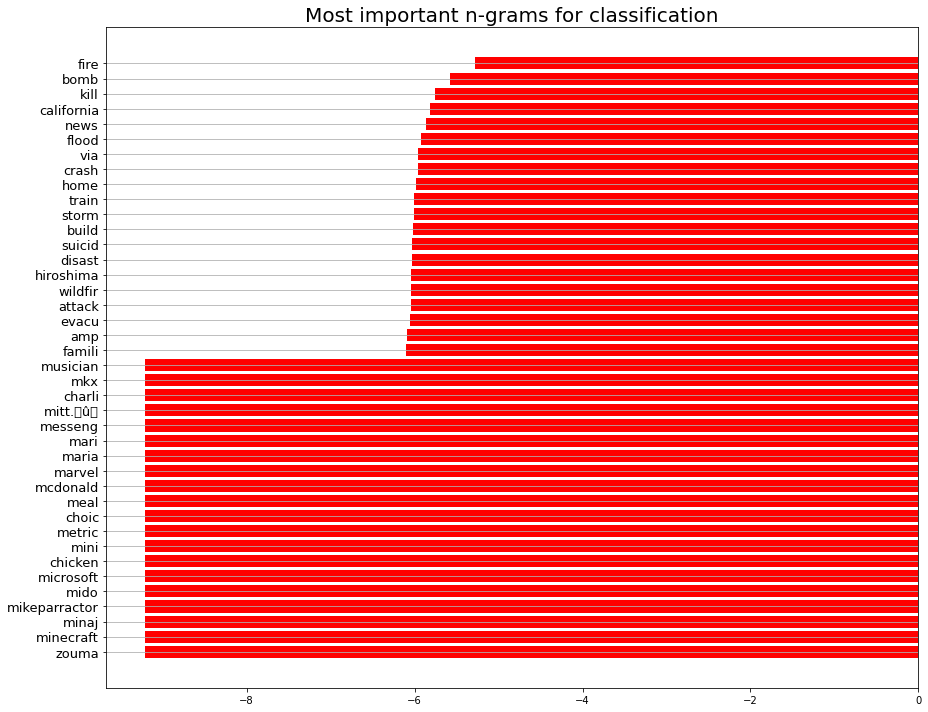

In [58]:
preproc.plot_coeffs(grid_search.best_estimator_.get_params()['steps'][1][1].coef_[0], grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names())

In [59]:
y_pred = grid_search.predict(X_test.text)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       869
           1       0.76      0.75      0.76       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523

